# Analysis of a Multi-Class Dataset by Projection onto a Very High-dimensional Feature Space



### Libraries & Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_pd = pd.read_csv('accent-mfcc-data-1.data', names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], index_col=0)
data = data_pd.to_numpy()

# An array of the correct class for each sample
sample_classes = np.array(data_pd.axes[0])


## Data Visualisation

#### Plot showing the whole dataset in the 2d feature space defined by linear PCA:

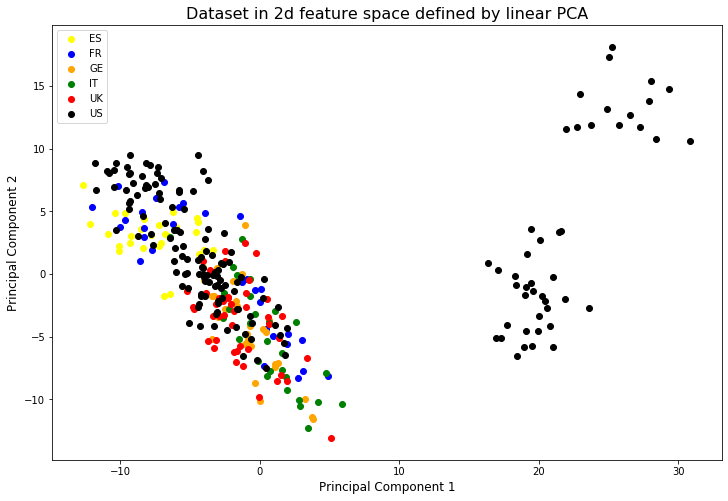

In [2]:
# Computes the PCA decomposition of a dataset using SVD
# The data is centred, then its SVD is computed, and the top PCs to be used are returned
def pca(data, pc_num):
    cntr_data = data - np.mean(data, axis=0)
    U, S, V = np.linalg.svd(cntr_data, full_matrices=True)
    pcs = V[:pc_num]
    return pcs, cntr_data

# Transform data with top 2 PCs
pca_2d, cntr_data = pca(data, 2)
transformed_2d = cntr_data @ pca_2d.T

# Define labels for classes and corresponding colours
colours = {0:'yellow', 1:'blue', 2:'orange', 3:'green', 4:'red', 5:'black'}
labels = {0:'ES', 1:'FR', 2:'GE', 3:'IT', 4:'UK', 5:'US'}
_, ax = plt.subplots(figsize=(12,8))

# Plots top 2 PCs of dataset in a 2D scatter plot (using transformed samples based on their labels)
cnt = 0
for unique_label in np.unique(sample_classes):
    idx = np.where(sample_classes==unique_label)
    ax.scatter(transformed_2d[:, 0][idx], transformed_2d[:, 1][idx], c=colours[cnt], label=labels[cnt])
    cnt += 1
    
plt.title("Dataset in 2d feature space defined by linear PCA", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend()
plt.show()


After visual inspection of the graph plotted, the dataset is not linearly separable in 2d as it cannot be divided into six distinct groups (one for each class) by six separate lines. We can see that the data points on the graph belonging to the different classes are mixed/clustered together in a way that means a straight line cannot be used to separate them.

## Determining if the dataset is linearly separable

#### Implementation of the multi-class perceptron:

In [3]:
from sklearn.utils import shuffle

# Converts samples from class string to an equivalent integer label (e.g. ES -> 0, FR -> 1)
def convert_sample_classes(sample_classes):
    sample_classes[sample_classes == 'ES'] = 0
    sample_classes[sample_classes == 'FR'] = 1
    sample_classes[sample_classes == 'GE'] = 2
    sample_classes[sample_classes == 'IT'] = 3
    sample_classes[sample_classes == 'UK'] = 4
    sample_classes[sample_classes == 'US'] = 5
    return sample_classes

# Creates an array for each class, consisting of +1 or -1 for each sample
# +1 if the sample is the class; -1 if the sample is not the class
def one_hot(Y, classes):
    class_arrs = []
    for c in range(classes):
        class_arr = []
        for y in Y:
            if y == c:
                class_arr.append(1)
            else:
                class_arr.append(-1)
        class_arrs.append(np.array(class_arr))
    return np.array(class_arrs)

# Implementation of the multi-class perceptron
def perceptron(X, Y, classes=6, features=12):
    n = 0.2 # learning rate
    w = np.zeros((classes,features)) # initialise weight matrix
    bias_X = np.ones((len(X), 1)) 
    X = np.hstack((X, bias_X)) # add a column of 1s to dataset X as a bias
        
    bias_w = np.ones((len(w), 1))
    w = np.hstack((w, bias_w)) # column of 1s also needs to be added to weight matrix 
    
    samples = Y.shape[1]

    # Training iterations
    for t in range(0, 10):
        
        Y = Y.T
        X, Y = shuffle(X, Y) # samples and correct output randomised together
        Y = Y.T
        
        # loop through samples
        for i in range(0, samples):
            x = X[i] # get sample i
            
            arr_a = np.arange(classes)
            idx_true = 0 # idx of class that should've predicted +1

            # loop through classes
            for j in range(classes):
                a = x @ w[j]
                arr_a[j] = a
                
                # checks class that should've predicted +1
                if Y[j][i] == 1:
                    idx_true = j
                                        
            # gets idx of max 
            idx_max = np.argmax(arr_a)
            
            # gets correct value class should've predicted
            y = Y[idx_max][i]
            
            # compares guess with y and updates if required
            if arr_a[idx_max] != y:
                w[idx_true] += n * x
                w[idx_max] -= n * x

    return w

# Calculate classification accuracy of multi-class perceptron - this can be used to determine if the dataset
# is linearly separable or not (if the accuracy is not 100%, it is not linearly separable)
def classification_accuracy(X, Y, w, classes=6):
    err_sum = 0
    samples = Y.shape[1] # number of samples in the dataset
    
    bias_X = np.ones((len(X), 1))
    X = np.hstack((X, bias_X)) 
    
    # checks if correct prediction is made for each sample (and records number of errors)
    for i in range(samples):
        x = X[i] # get sample i
        y = Y[:, i] # get correct class for sample
        class_predictions = np.arange(classes)
        
        # record prediction for each class
        for c in range(classes):
            a = w[c] @ x
            class_predictions[c] = a
        
        # get index of class with max prediction
        idx_max = np.argmax(class_predictions)
        
        # check if prediction is class that should have been predicted (if not, counts as an error)
        if y[idx_max] != 1:
            err_sum += 1
    
    accuracy = (1 - err_sum / samples) * 100
    return accuracy, err_sum

sample_classes = convert_sample_classes(sample_classes)


#### Using the multi-class perceptron to determine if the dataset is linearly separable in the original feature space - with 12d feature vectors:

In [4]:
NUM_CLASSES = 6 # 6 classes in the dataset
pc_num = 12 # number of principal components to be used

# No changes (slicing) need to be made to the data array as it already consists of only 12 principal components 
# (original feature space)
Y = one_hot(sample_classes, NUM_CLASSES)
w = perceptron(data, Y, NUM_CLASSES, pc_num)

accuracy, _ = classification_accuracy(data, Y, w, NUM_CLASSES)
print("Original feature space accuracy: " + str(accuracy) + '%')


Original feature space accuracy: 66.56534954407294%


The code above involves the training of the multi-class perceptron on the dataset (over ten iterations) in the original feature space (12d), which produces a weight matrix. After the training, the accuracy of the perceptron can be calculated to see if it is able to predict the correct class for every sample. If there are no errors (all classes predicted correctly), then the dataset is linearly separable. However, as can be seen by the result of the code above, the accuracy is around 66% and so because the accuracy is not 100% this means that the dataset is not linearly separable in the original feature space. 

#### Determining if the dataset is linearly spearable in the feature space defined by linear PCA:

In [5]:
Y = one_hot(sample_classes, NUM_CLASSES)

# Loops through feature space defined by linear PCA (2d to 12d)
for pc_num in range(2, 13):
    pca_pcs, cntr_data = pca(data, pc_num)
    
    # project data using the top PCs
    transformed = cntr_data @ pca_pcs.T
    
    w = perceptron(transformed, Y, NUM_CLASSES, pc_num)
    
    accuracy, _ = classification_accuracy(transformed, Y, w, NUM_CLASSES)
    
    print(str(pc_num) + "d feature space accuracy: " + str(accuracy) + '%')


2d feature space accuracy: 50.75987841945289%
3d feature space accuracy: 48.6322188449848%
4d feature space accuracy: 51.367781155015194%
5d feature space accuracy: 58.66261398176291%
6d feature space accuracy: 52.27963525835866%
7d feature space accuracy: 59.87841945288754%
8d feature space accuracy: 59.57446808510638%
9d feature space accuracy: 63.22188449848024%
10d feature space accuracy: 60.790273556231%
11d feature space accuracy: 67.4772036474164%
12d feature space accuracy: 70.82066869300911%


The code above loops through each feature space defined by linear PCA (2d to 12d) and checks the classification accuracy of the multi-class percetron trained on that feature space. As can be seen by the results, the perceptron is normally more accurate at predicting the correct class the greater the feature space, however even at 12d feature space, the accuracy is still only 60-70% and because this is not 100%, the dataset is not linearly separable in the feature space defined by linear PCA. 

#### Implementation of the normalized kernel matrix:

In [6]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp

# Define radial basis function kernel
def rbf_kernel(X, gamma):
    # calculates the squared Euclidian distances for every pair of points in the dataset, X
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)

    return exp(-gamma * mat_sq_dists)


def kernel_pca(X, pc_num, gamma, n):
    # centres X
    cntr_data = X - np.mean(X, axis=0)       
    
    K = rbf_kernel(cntr_data, gamma)
            
    # creates square matrix A (same dimensions as K; all values = 1/n)
    A = np.full((len(K), len(K[0])), 1/n)
    
    # normalises K
    K_n = K - A@K - K@A + (A@K)@A
    
    # applies SVD to normalised K:
    U, S, V = np.linalg.svd(K_n, full_matrices=True)
    pcs = V[:pc_num]
    
    # project data using the top PCs
    Z = K_n @ pcs.T
    
    return Z


#### Calculating the range of values to select the best value of gamma:

In [7]:
def calculate_gamma_range(X, features=12):
    epsilon = 0.05
    
    cntr_X = X - np.mean(X, axis=0) # centres the data, X

    # compute variance of each feature
    variances = np.arange(features, dtype=float)
    for feature in range(features):
        variances[feature] = np.var(cntr_X.T[feature])
        
    min_var = np.amin(variances)
    max_var = np.amax(variances)

    # calculate range of values to test for gamma
    gamma_min = 1 / (2 * (max_var + epsilon))
    gamma_max = 1 / (2 * (min_var - epsilon))

    # uses increments of 0.010 to define the set of gamma values to test
    gamma_range = []
    curr_gamma = gamma_min
    while curr_gamma < gamma_max:
        gamma_range.append(curr_gamma)
        curr_gamma += 0.010

    # also need to include max gamma calculated in the range
    gamma_range.append(gamma_max)
        
    return gamma_range


#### Grid Search:

In [10]:
# n is the number of samples in the dataset
n = 329

# feature space defined by non-linear PCA (13d - 329d)
n_f = 317

gamma_range = calculate_gamma_range(data, 12)

# Array used to store the number of errors in classification for each feature (in the feature space defined by 
# non-linear PCA) using each gamma value
arr_errors = np.arange(n_f * len(gamma_range)).reshape(n_f, len(gamma_range))

Y = one_hot(sample_classes, NUM_CLASSES)

min_top_pcs = -1
min_top_pcs_gamma = -1

# Loops through all feature space defined by non-linear PCA (13d to 329d), and for each gamma applies kernel PCA 
# (using RBF kernel), so a non-linear version of PCA can be obtained (Z).
# A perceptron is then trained for each of these (each Z) and the number of errors recorded (for the matrix plot).
for feature in range(13, n+1):
    gamma_cnt = 0
    for gamma in gamma_range:
        Z = kernel_pca(data, feature, gamma, n)
        w = perceptron(Z, Y, NUM_CLASSES, feature)
        _, num_errors = classification_accuracy(Z, Y, w, NUM_CLASSES)
        arr_errors[feature-13][gamma_cnt] = num_errors
        gamma_cnt += 1
        
        # dataset is linearly separable since there were no errors when testing classification accuracy
        if min_top_pcs == -1 and num_errors == 0:
            print("Dataset is linearly separable in the feature space defined by non-linear PCA.")
            min_top_pcs = feature
            min_top_pcs_gamma = gamma
    
print("Minimum number of top PCs needed: " + str(min_top_pcs))
print("Gamma value: " + str(gamma))


Dataset is linearly separable in the feature space defined by non-linear PCA.
Minimum number of top PCs needed: 277
Gamma value: 0.08193924109967507


#### Determining if the dataset is linearly separable in the feature space defined by non-linear PCA:

In the code above, an array is used to store the number of classification errors for each feature in the feature space defined by non-linear PCA for each gamma value in the range of gamma values calculated. If the number of errors is zero, this means that the dataset is linearly separable for that top PCs and gamma value. As can be seen by the results of running the code, the dataset is linearly separable with the minimum number of top PCs required being 277, using a gamma value of 0.0819 to 4 d.p. (max gamma value), as there were zero errors when testing the classification accuracy after training  the perceptron. 

#### Plot of matrix showing the results of the grid search:

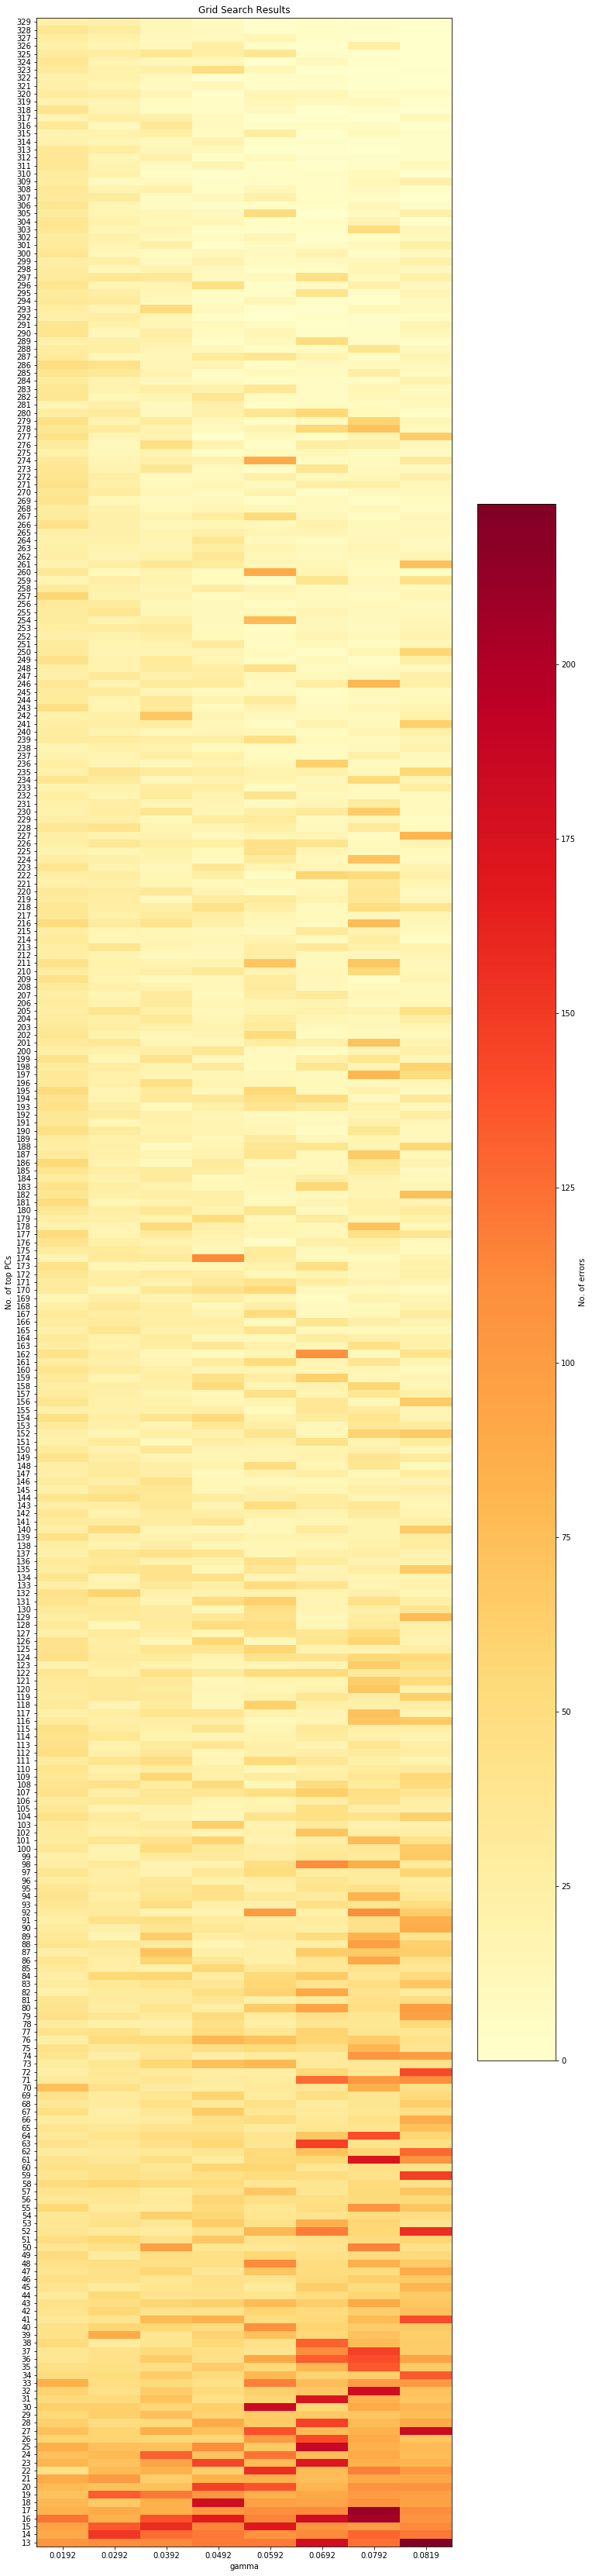

The plot above shows the results of the grid search.


In [14]:
plt.figure(figsize = (12,60))
plt.imshow(arr_errors, cmap='YlOrRd', interpolation='nearest', aspect='auto')

# y-axis is feature space defined by non-linear PCA (13d to 329d)
plt.gca().invert_yaxis()
plt.yticks(np.arange(1, 318, 1) - 1)
plt.gca().set_yticklabels(np.arange(13,330,1))

# range of gamma values to be shown on x-axis (these have been rounded to 4 d.p. so they can fit when displayed, 
# but the full values have been used in calculations)
x_range = np.around(gamma_range, 4)

plt.xticks(np.arange(0, 8, 1))
plt.gca().set_xticklabels(x_range)

plt.title('Grid Search Results')
plt.xlabel('gamma')
plt.ylabel('No. of top PCs')
cbar = plt.colorbar()
cbar.set_label('No. of errors')
plt.show()

print("The plot above shows the results of the grid search.")
